### Testing clear-sky LWd ensemble @ CUES

Estimate the clear-sky downward longwave using several different methods. Test these functions, and then plot some comparisons of the ensemble estimates of clear-sky downward longwave (LWd) against the measured LWd at the CUES site.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats

%matplotlib inline

Import the clear-sky downward longwave functions:

In [2]:
import lw_clr

---
---
# Test the LW functions:

Load observations from CUES site:

In [3]:
cues_ds = pd.read_pickle('CUES_L1_Temp_Rad_2017-2019.pkl').to_xarray()

#### Run ensemble of all these LW estimation methods:

Set up input variables from CUES observations:

In [4]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
Ta = T + 273.15 # temperature [K]
#Ta = Ta.where((Ta>250)&(Ta<300)) # I noticed some erroneous looking temperature values in Sept. 2018, we can try filtering those out here or leave them be for now
Qsi = cues_ds['upward looking solar radiation; uplooking Eppley Lab precision spectral pyranometer; (Watts/meter^2)']
elev = 2940 # meters

Run the ensemble function

In [5]:
lw_ensemble = lw_clr.ensemble(Ta, RH, elev)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Add all the results to the CUES dataset:

In [6]:
cues_ds = xr.merge([cues_ds, lw_ensemble])

Create a "day_flag" for hours throughout the year (so including shorter winter days) when we exect to see sunlight if there are no clouds. (I've chosen here to designate 8am-4pm as "day")

In [7]:
daystarthour = 8
dayendhour = 16
day_flag =  [1 if (pd.Timestamp(x).hour > daystarthour) & (pd.Timestamp(x).hour < dayendhour) else 0 for x in cues_ds['datetime'].values]
cues_ds['day_flag'] = (['datetime'],  day_flag)

Take a look at the dataset now

In [8]:
cues_ds

<xarray.Dataset>
Dimensions:                                                                                                                  (datetime: 1466937)
Coordinates:
  * datetime                                                                                                                 (datetime) datetime64[ns] 2017-03-01 ... 2019-12-30T23:59:00
Data variables:
    Platform relative humidity; platform temperature/relative humidity; (percent)                                            (datetime) float64 51.3 ... 91.5
    Platform temperature; platform temperature/relative humidity; (degrees Celsius)                                          (datetime) float64 -4.8 ... -7.2
    snow temperature 1; thermister 1; (degrees Celsius)                                                                      (datetime) float64 -0.1 ... nan
    snow temperature 2; thermister 2; (degrees Celsius)                                                                      (datetime) float64 -1.8 ... nan
    snow temperature 3; thermister 3; (degrees Celsius)                                                                      (datetime) float64 -51.9 ... nan
    snow temperature 4; thermister 4; (degrees Celsius)                                                                      (datetime) float64 -5.9 ... nan
    snow temperature 5; thermister 5; (degrees Celsius)                                                                      (datetime) float64 -6.0 ... nan
    snow temperature 6; thermister 6; (degrees Celsius)                                                                      (datetime) float64 -7.5 ... nan
    snow temperature 7; thermister 7; (degrees Celsius)                                                                      (datetime) float64 -23.2 ... nan
    snow temperature 8; thermister 8; (degrees Celsius)                                                                      (datetime) float64 -26.0 ... nan
    soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)                                                      (datetime) float64 0.3 ... 0.1
    soil temperature @ 10cm; soil temp at 10cm  center; (degrees Celsius)                                                    (datetime) float64 0.3 ... -1.2
    soil temperature @ 20cm; soil temp at 20cm  center; (degrees Celsius)                                                    (datetime) float64 0.6 ... 0.5
    soil temperature @ 30cm; soil temp at 30cm  center; (degrees Celsius)                                                    (datetime) float64 -0.7 ... -1.5
    soil temperature @ 40cm; soil temp at 40cm  center; (degrees Celsius)                                                    (datetime) float64 0.4 ... 0.3
    soil temperature @ 50cm; soil temp at 50cm  center; (degrees Celsius)                                                    (datetime) float64 0.9 ... 1.1
    soil temperature @ 60cm; soil temp at 60cm  center; (degrees Celsius)                                                    (datetime) float64 0.8 ... 0.2
    soil temperature @ 70cm; soil temp at 70cm  center; (degrees Celsius)                                                    (datetime) float64 1.1 ... 1.5
    soil temperature @ 80cm; soil temp at 80cm  center; (degrees Celsius)                                                    (datetime) float64 1.7 ... 1.6
    soil temperature @ 90cm; soil temp at 90cm  center; (degrees Celsius)                                                    (datetime) float64 2.0 ... 2.2
    CO2 concentration; bunker air temperature  atmospheric pressure and CO2 sensor; (parts per million)                      (datetime) float64 5.008e+03 ... 991.0
    bunker temperature; bunker air temperature  atmospheric pressure and CO2 sensor; (degrees Celsius)                       (datetime) float64 13.3 ... 11.3
    bunker air pressure  not adjusted; bunker air temperature  atmospheric pressure and CO2 sensor; (millibars)              (datetime) float64 714.0 ... 713.0
   

---
---
# Plot results:

Set up font sizes for plot

In [9]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Plotting functions:

In [10]:
# Function for making these plots
def plot_2dhist_LWensemble(x,y_,row,col):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax[row,col].imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax[row,col].plot([0,400],[0,400],'-',c='grey')
    ax[row,col].text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax[row,col].text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax[row,col].set_xlim([100,400])
    ax[row,col].set_ylim([100,400])
    ax[row,col].set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax[row,col].set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax[row,col].set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

def plot_2dhist_LW(x,y_):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax.plot([0,400],[0,400],'-',c='grey')
    ax.text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax.text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax.set_xlim([100,400])
    ax.set_ylim([100,400])
    ax.set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax.set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax.set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

For each estimation method, plot the estimated clear-sky LWd (y values) versus observed all-sky LWd (x values):

In [11]:
x = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
y = [cues_ds.lclr_angstrom1918,cues_ds.lclr_brunt1932,cues_ds.lclr_brutsaert1975,cues_ds.lclr_garratt1992,
     cues_ds.lclr_idsojackson1969, cues_ds.lclr_idso1981,cues_ds.lclr_iziomon2003,cues_ds.lclr_keding1989,
     cues_ds.lclr_niemela2001,cues_ds.lclr_prata1996,cues_ds.lclr_satturlund1979,cues_ds.lclr_swinbank1963,
     cues_ds.lclr_dilleyobrien1998,cues_ds.lclr_maykutchurch1973,
     cues_ds.lclr_campbellnorman1998,cues_ds.lclr_ohmura1982,cues_ds.lclr_efimova1961,
     cues_ds.lclr_mean, cues_ds.lclr_min, cues_ds.lclr_max]

Plot the estimated clear-sky downward longwave against observed downward longwave for each method (as well as our mean, min, max of all methods).

We expect these clear-sky methods to roughly match with observations when we actually do have clear-sky conditions.

When we have clouds, we should see the clear-sky methods underestimating the downward longwave flux.

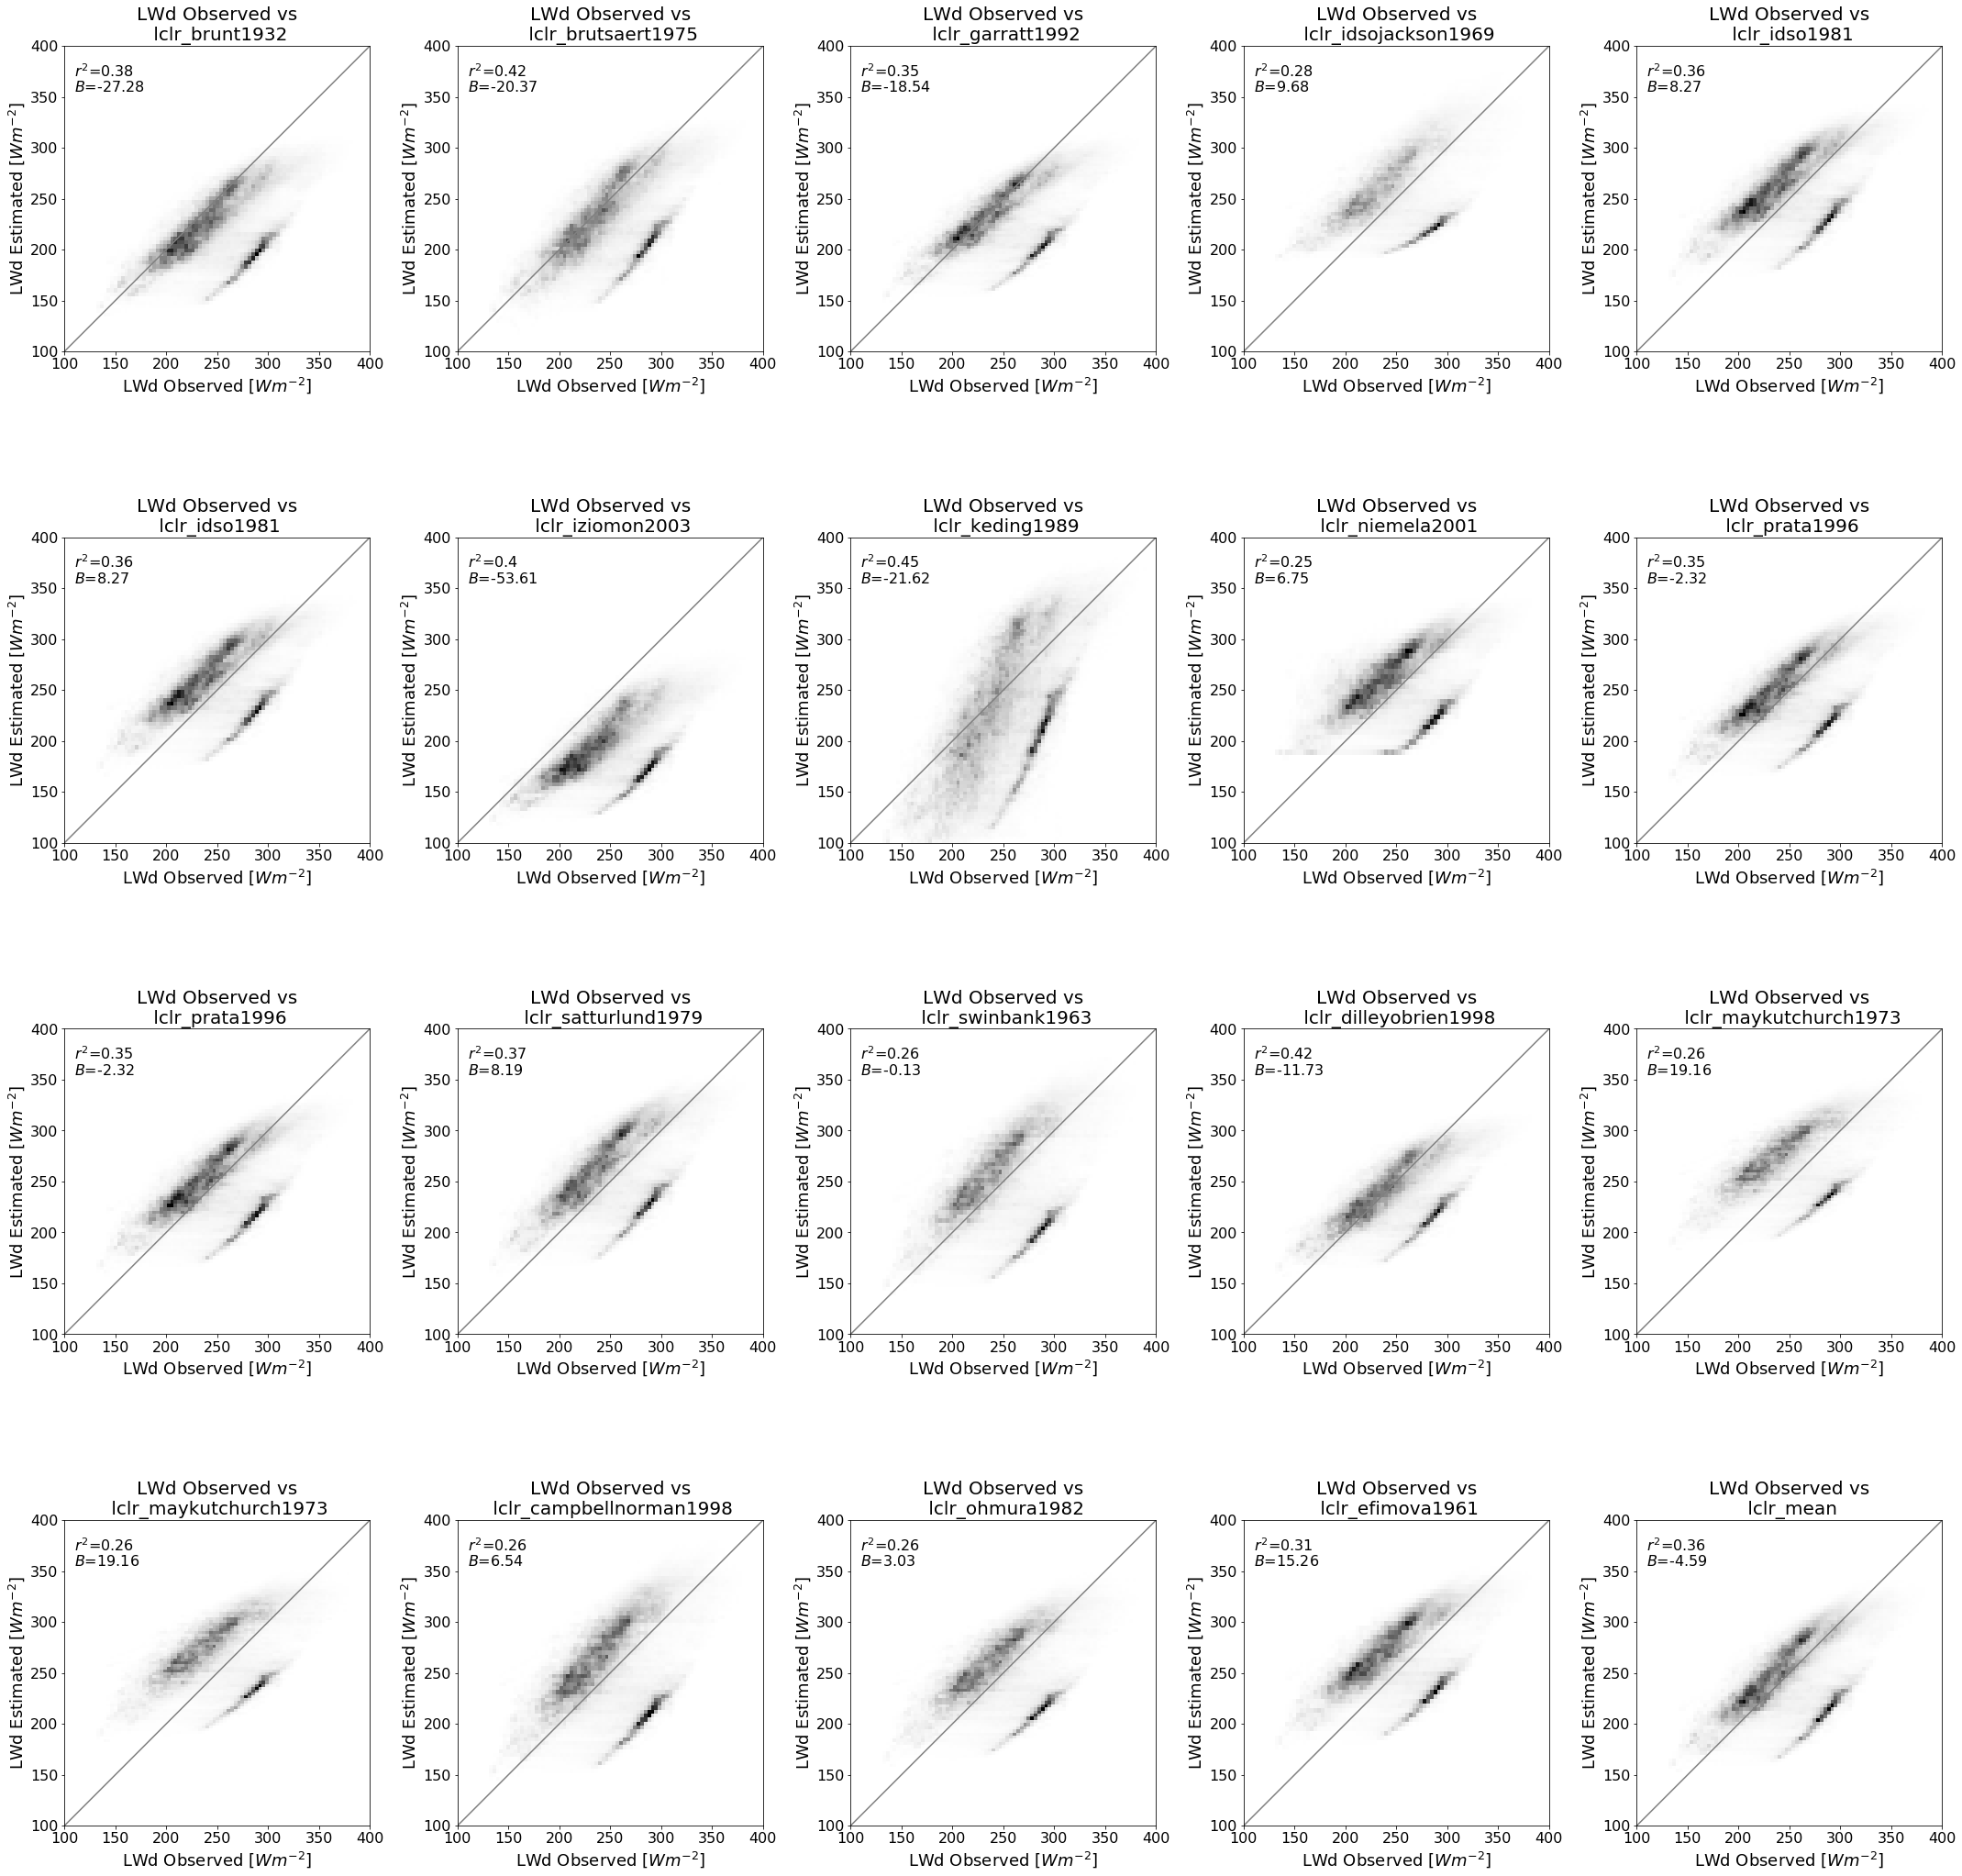

In [12]:
r = 4
c = 5
fig, ax = plt.subplots(r,c,figsize=(30,30))
for row in range(0,r):
    for col in range(0,c):
        try:
            plot_2dhist_LWensemble(x,y[(row*r)+col+1],row,col)
        except IndexError:
            pass
plt.tight_layout()

Now plot only for our known clear-sky conditions (sun flag = 1).

This corresponds to only daytime clear skies when the pyranometer saw the sun (therefore we aren't seeing night time clear skies).

*We can later use this sun flag as validation data to check a cloud detection method in another notebook (and compute a confusion matrix) (which I'll base on the Clear-Sky Index from Marty & Philipona, 2000).*

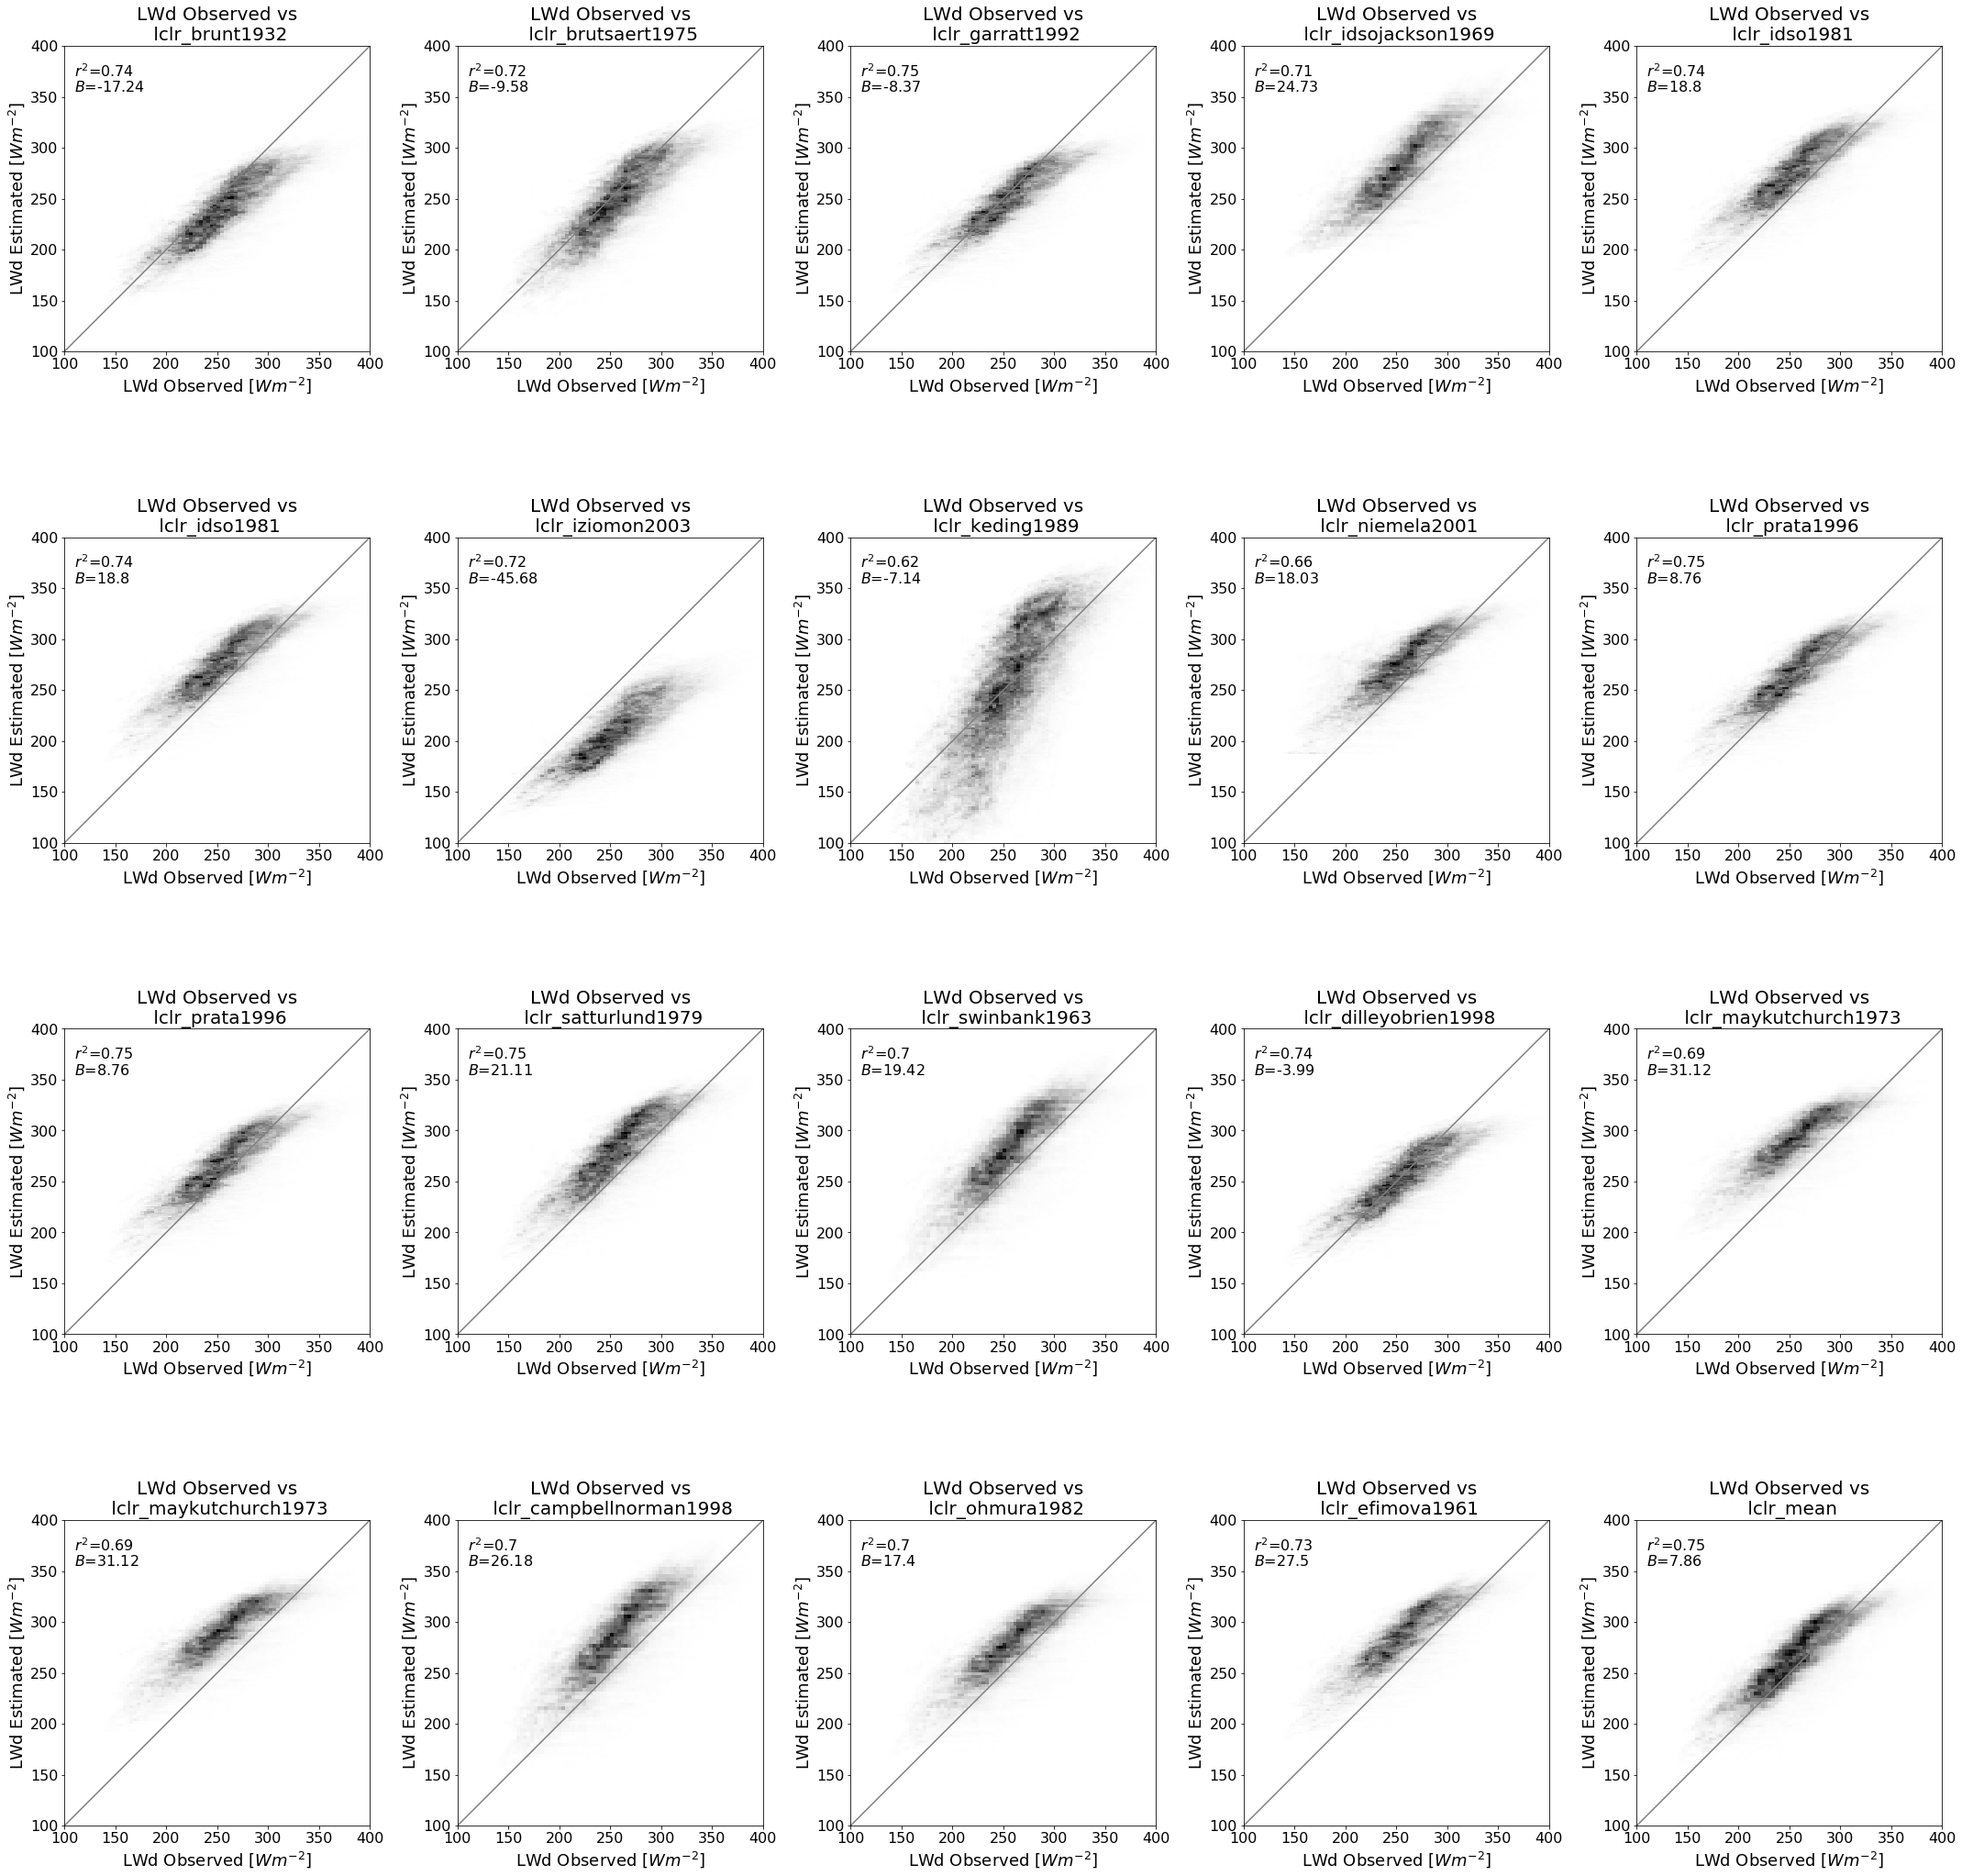

In [13]:
r = 4
c = 5
fig, ax = plt.subplots(r,c,figsize=(30,30))
for row in range(0,r):
    for col in range(0,c):
        try:
            plot_2dhist_LWensemble(x.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                                   y[(row*r)+col+1].where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
                                   ,row,col)
        except IndexError:
            pass
plt.tight_layout()

Plotting the ensemble mean against observed LWd for all data points, and then for only our known clear sky conditions (where sun flag = 1).

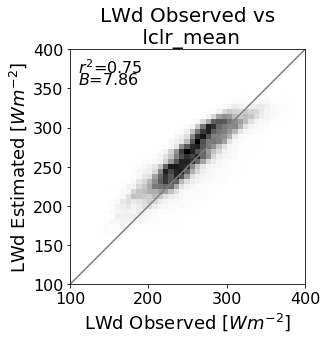

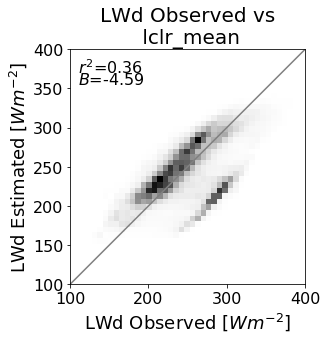

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
plot_2dhist_LW(x.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                cues_ds.lclr_mean.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1))

plt.tight_layout()


fig, ax = plt.subplots(figsize=(5,5))

plot_2dhist_LW(x,cues_ds.lclr_mean)

plt.tight_layout()



---
---